## California Plant Observation Analysis

CalFlora (www.calflora.org) provides a web interface for accessing plant observation records.  CalFlora aggregates records from the Consortium of California Herbaria (https://ucjeps.berkeley.edu/consortium/about.html) and iNaturalist (https://www.inaturalist.org/observations/export) databases.

Note: the iNaturalist database does have additional records (1.9M for CA) and a download limit of 200,000 observations at a time.  This could be useful in the future.

We can download plant observations from the CalFlora database here:

https://www.calflora.org/entry/wsearch.html

We want to (ideally) download all observations in the database.  Additional columns can be included from the 'customize' menu.  We are limited to downloading 50,000 rows of data at a time.

To accomplish this, I queried the database for all records within incremental date ranges, using trial and error to adjust date range if returned datafile contained 50,000 lines (meaning not all records would fit). At 2012, I switched to query by county, because date ranges became too cumbersome.

Citation:

Calflora: Information on California plants for education, research and conservation.
[web application]. 2017. Berkeley, California: The Calflora Database [a non-profit organization].
Available: www.calflora.org (Accessed: Mar 19, 2020).

### Objective:  predict relative likelihood of species for new observations

One obvious and very interesting question we can ask using this data is the following: given a specific location, which species am I most likely to find?  What is the ranking of species observation likelihood?

I'll try several approaches to answer this question, starting with attempting to distinguish observations of one species from another.

### Approach

1. Binomial Logistic Regression
2. Random Forest Classifier
3. Kernel Density Estimation

### Data Collection and Preprocessing

First, I'll collect data from the CalFlora database and prepare it for model training.

In [1]:
# imports
import pandas as pd
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import sqlite3
import re
import pickle
from joblib import dump, load

import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

In [2]:
# Notes for queries used to assemble complete dataset from CalFlora download form.
# file id : date range queried
# 0 : <1900
# 1 : 1900 - 1950
# 2 : 1950 - 1975
# 3 : 1975 - 1985
# 4 : 1985 - 1990
# 5 : 1990 - 1995
# 6 : 1995 - 1998
# 7 : 1998 - 2000
# 8 : 2000 - 2001
# 9 : 2001 - 2002
# 10: 2002 - 2003
# 11: 2003-01-01 - 2003-05-31
# 12: 2003-06-01 - 2003-11-30
# 13: 2003-12-01 - 2004-05-31
# 14: 2004-06-01 - 2004-12-31
# 15: 2005-01-01 - 2005-05-31
# 16: 2005-06-01 - 2005-12-31
# 17: 2006-01-01 - 2006-05-31
# 18: 2006-06-01 - 2006-12-31
# 19: 2007-01-01 - 2007-05-31
# 20: 2007-06-01 - 2007-12-31
# 21: 2008-01-01 - 2008-05-31
# 22: 2008-06-01 - 2008-12-31
# 23: 2009-01-01 - 2009-05-31
# 24: 2009-06-01 - 2009-12-31
# 25: 2010-01-01 - 2010-05-31
# 26: 2010-06-01 - 2010-12-31
# 27: 2011-01-01 - 2011-05-31
# 28: 2011-06-01 - 2011-12-31
# 29: >2012, Alameda, Alpine, Amador
# 30: >2012, Butte, Calaveras, Contra Costa, Colusa, Del Norte
# 31: >2012, El Dorado
# 32: >2012, Fresno
# 33: >2012, Glenn, Humbolt, Imperial
# 34: >2012, Inyo, Kings, Kern
# 35: >2012, Lake, Lassen, Madera
# 36: >2012, Los Angeles
# 37: 2012 - 2016, Marin
# 38: 2016 - 2018, Marin
# 39: >2018,  Marin
# 40: >2012, Mariposa, Mendocino, Merced
# 41: >2012, Mono, Monterrey, Modoc, Napa, Nevada
# 42: >2012, Orange, Placer, Plumas
# 43: >2012, Riverside
# 44: >2012, Sacramento
# 45: >2012, Santa Barbara, San Bernardino
# 46: >2012, San Benito
# 47: >2012, Santa Clara, Santa Cruz
# 48: 2012 - 2017, San Diego
# 49: >2017, San Diego
# 50: >2012, San Francisco, San Joaquin, San Luis Obispo
# 51: >2012, Shasta, Sierra, Siskiyou, Solano
# 52: >2012, San Mateo
# 53: >2012, Sonoma
# 54: >2012, Stanislaus, Sutter, Tehama, Tulare, Trinity
# 55: >2012, Tuolumne, Ventura, Yolo, Yuba

# read and concat all csv files into one dataframe
dfs = []
for n in range(56):
    dfs.append(pd.read_csv('calflora-records-'+str(n)+'.csv',low_memory=False))
    
df = pd.concat(dfs,ignore_index=True)

# for testing individual csv files as they are downloaded to make sure they didn't have 50k rows
#_df = pd.read_csv('calflora-records-55.csv',low_memory=False)
#_df

In [152]:
# rename columns to be more code-friedly
cols=df.columns.values

for i,col in enumerate(cols):
    renamed = col.lower()
    if renamed in  ['location quality','location description','common name','gross area count','gross area units','national ownership','national ownership code','number of plants','percent cover','phenology code','photo url']:
        cols[i] = renamed.replace(' ','_')
    elif renamed in ['accuracy: square meters']:
        cols[i] = 'accuracy_m2'
    elif renamed in ['elevation (m)']:
        cols[i] = 'elevation_m'
    elif renamed in ['error radius (m)']:
        cols[i] = 'error_radius_m'
    else:
        cols[i] = renamed
        
print (cols)

df.columns = cols

['id' 'genus' 'species' 'subspecies' 'taxon' 'observer' 'source' 'date'
 'county' 'location_quality' 'latitude' 'longitude' 'location_description'
 'accuracy_m2' 'calrecnum' 'collection' 'common_name' 'distribution'
 'elevation_m' 'error_radius_m' 'gross_area_count' 'gross_area_units'
 'grossarea' 'habitat' 'national_ownership' 'national_ownership_code'
 'notes' 'number_of_plants' 'percent_cover' 'phenology' 'phenology_code'
 'photo_url' 'plant' 'region']


In [153]:
# clean up data

# fields that we definitely want good data for:
# genus
# species
# latitude
# longitude
# date

# Note that some observations contain genus only, no species data
# for now, lets ignore those
df.dropna(subset=['genus','species','date'],inplace=True)

(1357177, 34)

In [154]:
# Note: datetime will not convert dates < 1700 or so, and will set as NaT instead.
# We can drop those funky dates afterwards.
df.date = pd.to_datetime(df.date,format='%Y-%m-%d',errors='coerce')
df.dropna(subset=['date'],inplace=True)

In [173]:
# make all text fields lowercase and remove any leading or trailing non-alphabetic characters
str_fields = df.select_dtypes(include='object')
df[str_fields.columns] = str_fields.apply(lambda x: x.astype(str).str.lower()).replace('nan','')

In [224]:
regex = r'^[^a-z]*|[^a-z]*$'
trim_cols = ['genus','species','subspecies','taxon']
df[trim_cols] = df[trim_cols].apply(lambda x: x.str.replace(regex,''))

In [246]:
# lets also ignore any cases where genus + species is not equal to taxon (except when subspecies listed),
# since these are likely to be poorly formatted data.
df = df[~((df.genus+' '+df.species!=df.taxon) & (df.subspecies==''))]

### Data Exploration

Now that the dataset is somewhat cleaned up, let's explore some relationships between features in the data.  I'll focus on the species name (genus + species) and observation date of each sample (observation).

In [247]:
# now we should be able to get a good sense of how many species we have in the database
df.groupby(df.genus+' '+df.species).id.count()

abelia xgrandiflora      5
abies amabilis           3
abies bracteata         54
abies concolor         932
abies grandis           82
                      ... 
zizyphus parryi          1
zostera japonica       729
zostera marina         462
zygadenus fremontii      1
zygophyllum fabago       8
Name: id, Length: 9787, dtype: int64

In [325]:
# lets plot the number of observations per year
s=df.groupby(df.date.dt.year)['id'].count()
# we can smooth the data to reduce year-to-year noise
y_vals=lambda std: gaussian_filter1d(np.log10(s.values),std)
x_vals=s.index

# we will also fit the smoothed data from 1955 - 2019 using an exponential fitting function
[m,b] = curve_fit (lambda x,m,b: m*x+b,x_vals[97:-2],y_vals(5)[97:-2])[0]
print ("Fitted parameters:\n  m  %0.2f\n  b  %0.2f"%(m,b))

1955 2019
Fitted parameters:
  m  0.05
  b  -89.80


2029

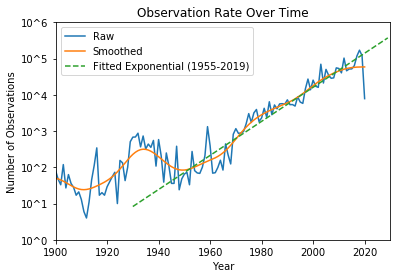

In [329]:
plt.plot(x_vals,y_vals(0.01),label='Raw')
plt.plot(x_vals,y_vals(5),label='Smoothed')
plt.plot(range(1930,2030),m*range(1930,2030)+b,label='Fitted Exponential (1955-2019)',linestyle='--')
plt.xlim(1900,2030)
plt.ylim(0,6)
plt.ylabel('Number of Observations')
plt.xlabel('Year')
plt.title('Observation Rate Over Time')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('10^%d'))
plt.legend()

The above plot shows the number of individual observations per year, from 1900 to 2019, with log scaling on the y-axis.  The trend is roughly exponential after about 1950, presumably due to increased ease of electronic data collection and storage.

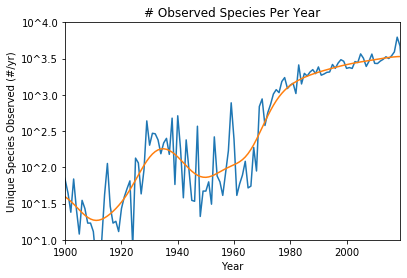

In [357]:
# lets plot the number of unique species observations per year
s = df.groupby(df.date.dt.year).apply(lambda x: (x.genus+' '+x.species).nunique())
y_vals=lambda std: gaussian_filter1d(np.log10(s.values),std)
x_vals=s.index
plt.plot(x_vals,y_vals(0.01))
plt.plot(x_vals,y_vals(5))
plt.xlim(1900,2019)
plt.ylim(1,4)
plt.ylabel('Unique Species Observed (#/yr)')
plt.xlabel('Year')
plt.title('# Observed Species Per Year')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('10^%0.1f'))

This plot shows the number of unique species observed each year, from 1900 to 2019.  Evidently, not a lot of observations were made between about 1945 and 1965.  I wonder if this has any thing to do with WWII and the political climate at the time?

These days, people are observing around 3000 species per year.

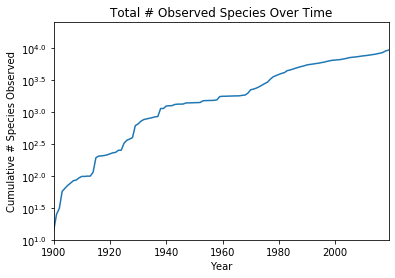

In [410]:
# lets plot the total number of species in the database over time
# we can do this by finding the first occurence of each species (not including subspecies) and then
# bin by year and do a cumulative sum.
first_occurence = df.groupby(df.genus+' '+df.species).date.min().dt.year
hist, _ = np.histogram(first_occurence,bins=120,range=(1900,2020))
y_vals = np.cumsum(hist)
x_vals = np.arange(1900,2020)
plt.plot(x_vals,np.log10(y_vals))
plt.xlim(1900,2019)
plt.ylim(1,4.4)
plt.ylabel('Cumulative # Species Observed')
plt.xlabel('Year')
plt.title('Total # Observed Species Over Time')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('$10^{%0.1f}$'))
#df[(df.genus=="abies")&(df.species=="amabilis")]

The above plot shows the total number of distinct species in the database over time.  We can see that many new species are added to the database over time, even today.  For example, the database contains approximately 1000 different species with observations before about 1940, but nearly 10,000 by 2019!

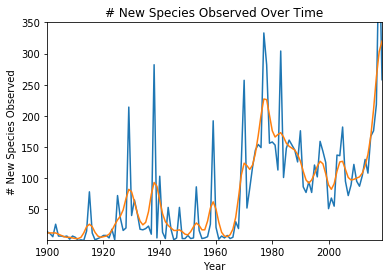

In [378]:
# lets plot the number of new species added to the database over time
first_occurence = df.groupby(df.genus+' '+df.species).date.min().dt.year
hist, _ = np.histogram(first_occurence,bins=120,range=(1900,2020))
y_vals=lambda std: gaussian_filter1d(hist,std)
x_vals = np.arange(1900,2020)
plt.plot(x_vals,y_vals(0.1))
plt.plot(x_vals,y_vals(1.5))
plt.xlim(1900,2019)
plt.ylim(1,350)
plt.ylabel('# New Species Observed')
plt.xlabel('Year')
plt.title('# New Species Observed Over Time')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

This plot shows the number of new species observed each year (smoothed to reduce noise).  Interestingly, in the last few years the number of new species added to the database has skyrocketed!  Since about 1970, (usually) more than 100 new species have been added per year.

Note that often many new species are added at a time, showing up as spikes on the plot.  Presumably, this is caused by botanical surveys, where many observations are made cooperatively over a short time period.  It seems likely that these surveys were the primary source of observations before technology in more recent years has permitted a larger number of individuals to independently collect data.

/Users/christoph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


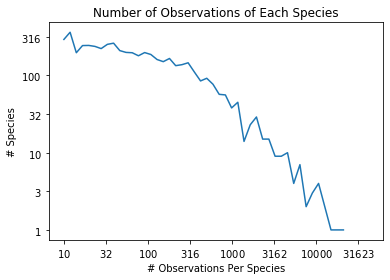

In [417]:
# how many observations do we have of each species in the database?
counts = df.groupby(df.genus+' '+df.species).id.count()
hist, x_vals = np.histogram(np.log10(counts),bins=50,range=(1,np.log10(counts.max())))
plt.plot(x_vals[:-1],np.log10(hist))
plt.ylabel('# Species')
plt.xlabel('# Observations Per Species')
plt.title('Number of Observations of Each Species')
log_format_func = lambda value, ticknumber: '$%0.0f$'%(10**(value))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(log_format_func))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(log_format_func))

This plot shows the distribution of total observations per species, with log-log scaling. Most of the species in the database do not have many observations.  Those with fewer than 100 observations will probably be of limited use in this analysis.

In [432]:
# total number of species
species = df.groupby(df.genus+' '+df.species).id.count()

# how many species with more than 1000 observations?
print (len(species), len(species[species>1000]))

# for now, let just look at those with 1000 observations or more.
common_species = species[species>1000]

print (common_species)

df = df[(df.genus+' '+df.species).isin(common_species.index)]

9787 231
acacia melanoxylon         1509
acer macrophyllum          1105
achillea millefolium       2208
acmispon glaber            1103
adenostoma fasciculatum    3026
                           ... 
volutaria tubuliflora      3198
vulpia myuros              3530
washingtonia filifera      1069
washingtonia robusta       2267
yucca brevifolia           1132
Name: id, Length: 231, dtype: int64


In [511]:
# lets now plot some species distributions

# how about oaks and pines.  Which subspecies are present in the subset?
print (df[df.genus=='quercus'].groupby(df.species+' : ' +df.common_name).id.count())
print (df[df.genus=='pinus'].groupby(df.species+' : '+df.common_name).id.count())

agrifolia : coast live oak                3256
agrifolia : southern coast live oak         26
chrysolepis : gold cup live oak           1614
douglasii : blue oak                      2605
durata : leather oak                      1738
durata : san gabriel mtns. leather oak      24
kelloggii : california black oak          1913
lobata : valley oak                       3039
wislizeni : interior live oak             1886
wislizeni : live oak                       201
xalvordiana : alvord's oak                1956
Name: id, dtype: int64
coulteri : coulter pine                     1279
monophylla : single leaf pinyon             1125
ponderosa : jeffrey pine                       1
ponderosa : north plateau ponderosa pine      49
ponderosa : pacific ponderosa pine            17
ponderosa : washoe pine                        4
ponderosa : yellow pine                     1213
radiata :                                      1
radiata : monterey pine                     3030
sabiniana : bull pi

In [4]:
# Now, let's plot some observed distributions on a map of California using GeoPandas

# specify coordinate references system
crs = {'init':'epsg:4326'}

# I downloaded a shape file of the CA boundary here: https://data.ca.gov/dataset/ca-geographic-boundaries
ca = gpd.read_file('ca-state-boundary/CA_State_TIGER2016.shp')
ca = ca.to_crs(crs)

In [ ]:
geometry = df.apply(lambda x: Point((x.longitude,x.latitude)),axis=1)

# for when I have 25 minutes to run this...
# collect any points that are not within the bounds of califonia
valid_points=geometry.apply(lambda x: ca.contains(x))

In [ ]:
# not sure why, but valid_points is acting weird.  making it into a new series fixes things...
_ = pd.Series(np.array(valid_points.values).T[0])
_.index = valid_points.index
geometry = geometry[_]
df = df[_]

In [6]:
# let's now add random points to geometry and df so we can use them later
n_randoms = 100000
latitude_min = df.latitude.min()
latitude_max = df.latitude.max()
longitude_min = df.longitude.min()
longitude_max = df.longitude.max()
random_latitudes = np.random.random(n_randoms)*(latitude_max-latitude_min)+latitude_min
random_longitudes = np.random.random(n_randoms)*(longitude_max-longitude_min)+longitude_min
random_geometry = [Point(x,y) for (x,y) in zip(random_longitudes,random_latitudes)]
# subset only the valid points
valid_points = np.where(np.array([ca.contains(p) for p in random_geometry]))[0]
random_geometry = pd.Series(random_geometry)[valid_points].values
print (len(random_geometry))

44467


In [7]:
random_df = pd.DataFrame([random_longitudes,random_latitudes]).T
random_df.columns = ['longitude','latitude']
random_df = random_df.iloc[valid_points].reset_index()
random_df['genus'] = 'random'
random_df['species'] = 'random'

In [921]:
# save these states before overwritting with new randoms
df.to_pickle('calflora_db_common_species_no_randoms.pkl')
geometry.to_pickle('calflora_db_common_species_geometry_no_randoms.pkl')

In [3]:
df = pd.read_pickle('calflora_db_common_species_no_randoms.pkl')
geometry = pd.read_pickle('calflora_db_common_species_geometry_no_randoms.pkl')

In [8]:
df = df.append(random_df,sort=False,ignore_index=True)
geometry = geometry.append(pd.Series(random_geometry),ignore_index=True)

In [2]:
# save these states before overwritting with new randoms
#df.to_pickle('calflora_db_common_species_with_randoms.pkl')
#geometry.to_pickle('calflora_db_common_species_geometry_with_randoms.pkl')
df = pd.read_pickle('calflora_db_common_species_with_randoms.pkl')
geometry = pd.read_pickle('calflora_db_common_species_geometry_with_randoms.pkl')

In [5]:
geo_df = gpd.GeoDataFrame(df,crs=crs,geometry=geometry.values)

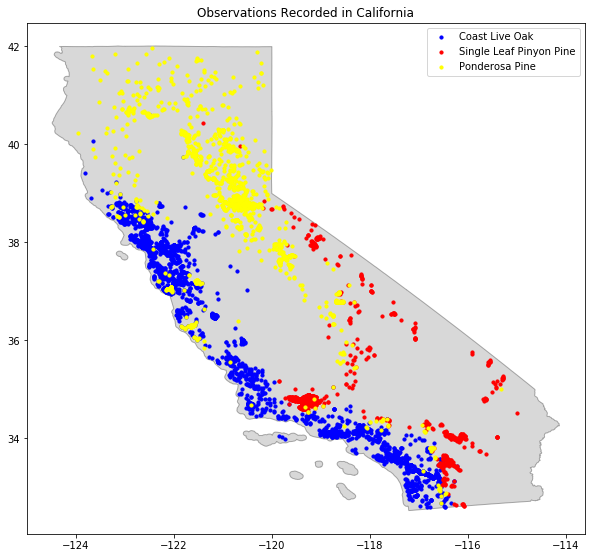

In [5]:
# I'll compare the observations of coast live oak to pinyon pine to ponderosa pine.
# all are common tree species, but they have fairly different distributions.
fig,ax = plt.subplots(figsize=(10,10))
ca.plot(ax=ax,alpha=0.3,color='grey',edgecolor='k')
get_species = lambda genus,species: geo_df[(geo_df.genus+' '+geo_df.species) == genus+' '+species] 
get_species('quercus','agrifolia').plot(ax=ax,markersize=10,color='blue',label='Coast Live Oak')
get_species('pinus','monophylla').plot(ax=ax,markersize=10,color='red',label='Single Leaf Pinyon Pine')
get_species('pinus','ponderosa').plot(ax=ax,markersize=10,color='yellow',label='Ponderosa Pine')
plt.title('Observations Recorded in California')
plt.legend()

I've plotted above the observed distributions of Coast Live Oak (blue), Single Leaf Pinyon Pine (red), and Ponderosa Pine (yellow) within the state of California.  These three species each have clearly different distributions, but with some regions of overlap.

### Predicting Species from Observation Location

First, I thought I would treat this as a simple binary classification problem.  Given two species distributions, can I train a model to classify new observations well enough to both generalize the distributions, but not overfit the training data?  I'll start by using logistic regression.

Notes for myself:
- Here is a useful article providing some ideas for how to work with geospatial data.  Suggests clustering analysis.
https://heartbeat.fritz.ai/working-with-geospatial-data-in-machine-learning-ad4097c7228d
- Another useful article describing how to use geopandas package to plot dataframe lat,long onto real world map:
https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
- Scikit-learn documentation on clustering algorithms:
https://scikit-learn.org/stable/modules/clustering.html
- Ideas:
    - perform clustering analysis to segregate bioregions
        - we would want to identify clusters of observations which tend to have similar species
    - logistic regression (or some other method) to estimate species range
    - predict likelihood of observation of a given species at a given location (how??)
        - perhaps using maximum likelihood?

### Binomial Logistic Classifier

First, let's limit ourselves to working with all observations from only two species.  Given a new observation (GPS coordinate), can our model reasonably predict which species was observed?

If this works for two species, we may be able to extend it to include more species.  This would then provide a way for us to get estimates for the relative likelihood of observing each species at a given GPS location.

In [709]:
# let's implement a logistic regression classifier to predict whether an observation belongs to
# one species distribution vs another
# we can start with coast live oak vs pinyon pine, then add in ponderosa pine

# first, we need to ready the data, changing any non-numeric fields to numeric or dropping them and making sure we don't have any missing values
#labels = {'pinus monophylla' : 0, 'quercus agrifolia' : 1}
labels = {'pinus ponderosa' : 0, 'quercus agrifolia' : 1}
train = df[(df.genus+' '+df.species).isin(labels.keys())][['genus','species','longitude','latitude']].copy(deep=True)

# the only columns of relevance will be species (1/0), latitude, longitude
print (train.isna().sum()) # should have zero NaN values

train['labels'] = (train.genus+' '+train.species).map(labels)
train.drop(['genus','species'],axis=1,inplace=True)

print (train)

genus        0
species      0
longitude    0
latitude     0
dtype: int64
          longitude   latitude  labels
61      -116.566116  33.158948       1
3290    -120.220001  35.189999       1
3312    -120.129997  35.180000       1
3332    -120.180000  35.020001       1
3354    -120.110001  35.080002       1
...             ...        ...     ...
1389256 -118.938402  34.359811       1
1389484 -119.326898  34.637322       0
1390095 -118.651401  34.265006       1
1390295 -118.771749  34.185002       1
1392797 -121.161832  39.514882       0

[4566 rows x 3 columns]


In [710]:
# define test set, training set
x_train, x_test, y_train, y_test = train_test_split(train.drop('labels',axis=1),train['labels'], test_size=0.3)

print (x_train)
print (y_train)

# train and predict using logistic regression
logmodel = LogisticRegression(solver='lbfgs')
logmodel.fit(x_train,y_train)
predictions = logmodel.predict(x_test)
probs = logmodel.predict_proba(x_test)
probs = pd.DataFrame(probs,columns=['probability_%d'%n for n in range(2)])

print (metrics.classification_report(y_test,predictions))
print ("Accuracy:",metrics.accuracy_score(y_test, predictions))



          longitude   latitude
5679    -120.370003  38.700001
917472  -122.461830  38.002553
79407   -121.827090  36.880200
1194385 -117.140447  33.040888
1121048 -121.196035  36.505773
...             ...        ...
4005    -120.419998  35.400002
57206   -116.770116  33.814102
839682  -117.710587  34.087389
410366  -121.831000  36.280000
253713  -117.422211  33.604870

[3196 rows x 2 columns]
5679       0
917472     1
79407      1
1194385    1
1121048    1
          ..
4005       1
57206      0
839682     1
410366     1
253713     1
Name: labels, Length: 3196, dtype: int64
              precision    recall  f1-score   support

           0       0.95      0.74      0.83       380
           1       0.91      0.99      0.95       990

    accuracy                           0.92      1370
   macro avg       0.93      0.86      0.89      1370
weighted avg       0.92      0.92      0.91      1370

Accuracy: 0.9182481751824818


          longitude   latitude  labels  predictions
1348032 -123.054661  38.564988       1            1
7915    -120.529999  35.220001       1            1
1197464 -117.161026  32.925709       1            1
1335885 -122.574962  38.454245       1            1
830451  -117.827172  34.154831       1            1
...             ...        ...     ...          ...
1091033 -120.436109  34.707022       1            1
980469  -121.626475  36.289572       0            1
5144    -120.650002  38.869999       0            0
993135  -120.896924  39.371475       0            0
1176972 -122.112160  37.334417       1            1

[1370 rows x 4 columns]
0          POINT (-122.508484 37.550299)
1          POINT (-122.508244 37.550098)
2          POINT (-122.503929 37.550514)
3          POINT (-122.454649 37.523857)
4          POINT (-122.454147 37.523254)
                       ...              
1401691        POINT (-121.0625 39.5625)
1401692        POINT (-121.0625 39.5625)
1401693        POINT (-

Text(0.5, 1, 'Logistic Regression Performance for Coast Live Oak (blue) vs Ponderosa Pine (green)')

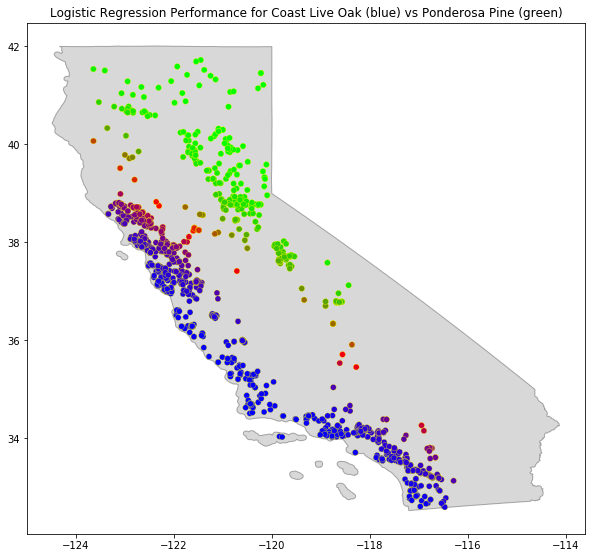

In [712]:
# reform test set to include predictions from model
x_test['labels'] = y_test
x_test['predictions'] = predictions
for i,c in enumerate(probs.columns):
    x_test[c] = probs.values[:,i]
#x_test[probs.columns] = probs.values

# create geodataframe
geo_df = gpd.GeoDataFrame(x_test,crs=crs,geometry=(geometry.loc[x_test.index]).values)
fig,ax = plt.subplots(figsize=(10,10))
ca.plot(ax=ax,alpha=0.3,color='grey',edgecolor='k')

# create colormap for predicted probabilities
norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.brg)
colors = [mapper.to_rgba(x) for x in x_test.probability_0]
geo_df.plot(ax=ax,markersize=35,c=colors,label='0',edgecolor='yellow',linewidth=0.3)
plt.title('Logistic Regression Performance for Coast Live Oak (blue) vs Ponderosa Pine (green)')

The plot above shows how well our logistic classifier distinguishes between Ponderosa Pine and Coast Live Oak observations in our test set.  Observations are colored blue when the probability of being Ponderosa Pine is close to 0, green when it is close to 1 (100%), and red when there is roughly equal chance of being either one.

There is some overlap in the distributions of these observations, and in those regions we tend to see more red points.  The model seems to do reasonably well at identifying the correct species in regions where there is little species overlap.  However, as we will see, logistic regression does very poorly when there is more nonlinear variation between the species distributions.

In [148]:
# let's write a function to do this automatically so we can compare results for different species

# pass list of species to include in training
def train_logistic_classifier(species, test_size=0.3):

    labels_dict = {s : n for n,s in enumerate(species)}
    train = df[(df.genus+' '+df.species).isin(labels_dict.keys())][['genus','species','longitude','latitude']].copy(deep=True)

    # the only columns of relevance will be species (1/0), latitude, longitude
    #print (train.isna().sum()) # should have zero NaN values
    
    train['labels'] = (train.genus+' '+train.species).map(labels_dict)
    #labels = (train.genus+' '+train.species).map(labels_dict)
    train = train.drop(['genus','species'],axis=1)
    
    #print (train)

    x_train, x_test, y_train, y_test = train_test_split(train.drop('labels',axis=1),train.labels,test_size=test_size)
    
    #print (x_train)
    #print (y_train)
    
    # train and predict using logistic regression
    logmodel = LogisticRegression(solver='lbfgs')
    logmodel.fit(x_train,y_train)
    predictions = logmodel.predict(x_test)
    probs = logmodel.predict_proba(x_test)
    probs = pd.DataFrame(probs,columns=['probability_%d'%n for n in range(2)])
    
    print (metrics.classification_report(y_test,predictions))
    print ("Accuracy:",metrics.accuracy_score(y_test, predictions))
    #print (probs)
    #print (x_test)

    # reform test set to include predictions from model
    x_test['labels'] = y_test
    x_test['predictions'] = predictions
    for i,c in enumerate(probs.columns):
        x_test[c] = probs.values[:,i]

    return (x_test, train)
 
x_test, train = train_logistic_classifier(['pinus monophylla','quercus lobata'])

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       346
           1       1.00      0.94      0.97       903

    accuracy                           0.95      1249
   macro avg       0.93      0.96      0.94      1249
weighted avg       0.96      0.95      0.95      1249

Accuracy: 0.9519615692554043


In [179]:
# and let's write an automatic plotting function

def plot_model_pred (data,n_classes=2,title='',plot_label='0'):

    (x_test, train) = data
    
    geometry_test = (geometry.loc[x_test.index]).values
    geometry_train = (geometry.loc[train.index]).values

    # create geodataframe
    geo_df_test = gpd.GeoDataFrame(x_test,crs=crs,geometry=geometry_test)
    geo_df_train = gpd.GeoDataFrame(train,crs=crs,geometry=geometry_train)
    
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,20))
    ca.plot(ax=ax1,alpha=0.3,color='grey',edgecolor='k')
    ca.plot(ax=ax2,alpha=0.5,color='grey',edgecolor='k')

    # create colormap for predicted probabilities
    norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.brg)
    colors = [mapper.to_rgba(x) for x in x_test['probability_'+plot_label]]
    geo_df_test.plot(ax=ax1,markersize=55,c=colors,label=plot_label,edgecolor='yellow',linewidth=0.3)
    
    colors = ['green','blue','red']
    for i in range(n_classes):
        if i==int(plot_label):
            #color = 'green'
            continue # we'll plot afterwards so its on top
        else:
            color = 'mediumblue'
        geo_df_train[geo_df_train.labels==i].plot(ax=ax2,color=color,markersize=15,alpha=0.5)
        #geo_df_train[geo_df_train.labels==1].plot(ax=ax2,color='blue',markersize=15,alpha=0.5)
        
    geo_df_train[geo_df_train.labels==int(plot_label)].plot(ax=ax2,color='forestgreen',markersize=15,alpha=0.5)
    
    ax1.set_title(title)
    ax2.set_title('True Distributions')

              precision    recall  f1-score   support

           0       0.55      0.57      0.56      1810
           1       0.95      0.94      0.95     14793

    accuracy                           0.90     16603
   macro avg       0.75      0.76      0.75     16603
weighted avg       0.90      0.90      0.90     16603

Accuracy: 0.9026079624164308


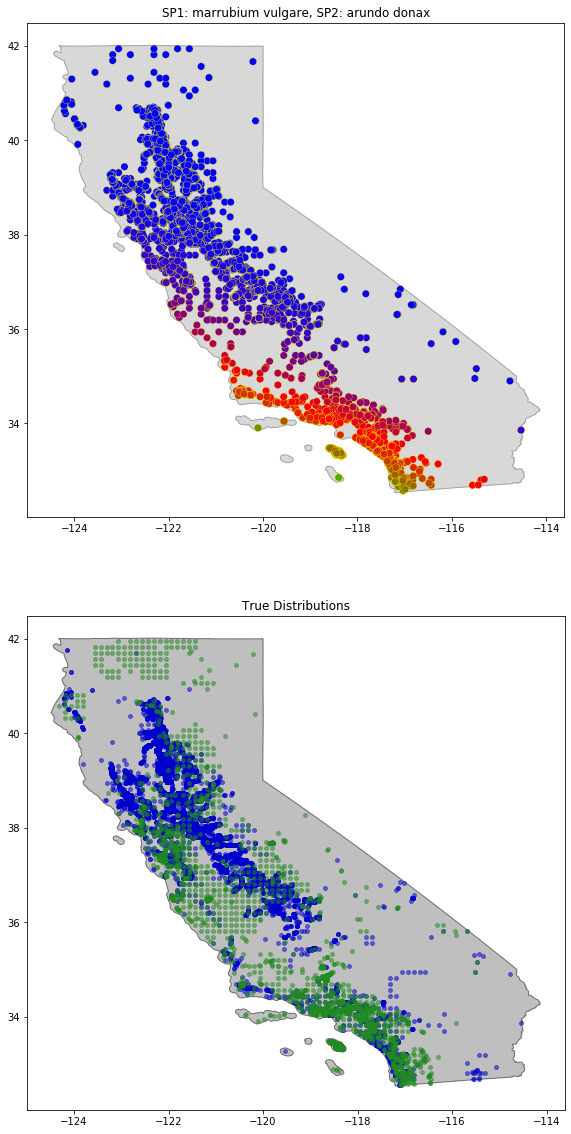

In [180]:
# let's grab two very common species
_ = df.groupby(df.genus+' '+df.species).id.count()
species = _[_>5000].sample(2).index
species = ['marrubium vulgare','arundo donax']
[sp1,sp2] = species

#plot_model_pred (train_logistic_classifier(['pinus monophylla','quercus lobata']))
plot_model_pred (train_logistic_classifier([sp1,sp2]),title='SP1: '+sp1+', SP2: '+sp2)

#### Evaluation of Logistic Classifier

The above plots shows the true distributions (bottom figure) and predicted species for a set of test observations (top figure) for marrubium vulgare (common horehound) and arundo donax (giant reed).

From the bottom figure, we can see that the distributions of observations of these two species overlap in northern California, but in a complex manner.  Marrubium vulgare (green points in bottom figure) has a dense group of observations in coastal California, but also in far north-central California.  The logistic classifier does not have enough parametric flexibility to fit these nonlinear distributions in a believable way.  Instead, we see that the model considers more northern observations to be more likely arundo donax (top figure: blue points are high confidence a. donax predictions; bottom figure: blue points are true a. donax observations), and more southern observations to be m. vulgare with higher probability (top figure: green points are high confidence m. vulgare predictions; bottom figure: green points are true m. vulgare observations).

Clearly, this classifier does not work well for two-species classification with complex overlapping distributions.

### Random Forest Implementation

The next model I chose to implement in an effort to improve predictability of complex species distributions is a random forest classifier.  Decision trees are able to repeatedly subdivide the feature space looking for ways to separate classes.  For our 2D map of observations, this means much better adaptability to the observed distributions than a logistic classifier.

Here is a good article on implementing a random forest classifier (https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76)

In [7]:
# specify species to include
# if use_randoms, use random observations as one 'species', and choose 1 species
def train_random_forest(species, test_size=0.3, n_randoms=1000, generate_observations=100):

    n_species = len(species)
    #print (n_species)
    
    use_randoms = False
    new_observations = None
    
    # df will recognize random random but not just random
    for i,s in enumerate(species):
        if s == 'random':
            species[i] = "random random"
            use_randoms = True
    
    #species = ['pinus monophylla','quercus lobata']
    labels_dict = {s : n for n,s in enumerate(species)}
    train = df[(df.genus+' '+df.species).isin(labels_dict.keys())][['genus','species','longitude','latitude']].copy(deep=True)

    #print (labels_dict)
    
    # subset randoms if we need to
    if use_randoms:
        _not_randoms = train[train.genus!='random']
        _randoms = train[train.genus=='random'].sample(n_randoms)
        new_observations = train[train.genus=='random'].drop(_randoms.index,axis=0).sample(generate_observations).copy(deep=True)
        #print (new_observations)
        new_observations = new_observations.drop(['genus','species'],axis=1)
        train = _not_randoms.append(_randoms)
        
    # the only columns of relevance will be species (1/0), latitude, longitude
    #print (train.isna().sum()) # should have zero NaN values
    
    train['labels'] = (train.genus+' '+train.species).map(labels_dict)
    train = train.drop(['genus','species'],axis=1)
    
    #print (train)
    
    x_train, x_test, train_labels, test_labels = train_test_split(train.drop('labels',axis=1),train.labels,test_size=test_size,random_state=50)
    
    #print (x_train)
    #print (y_train)
    
    # train and predict using random forest
    model = RandomForestClassifier(n_estimators=100,random_state=50,max_features='sqrt',n_jobs=-1,verbose=1)
    
    model.fit(x_train,train_labels)
    
    predictions = model.predict(x_test)
    probs = model.predict_proba(x_test)
    #print (probs)
    probs = pd.DataFrame(probs,columns=['probability_%d'%n for n in range(n_species)])
    
    print (metrics.classification_report(test_labels,predictions))
    print ("Accuracy:",metrics.accuracy_score(test_labels, predictions))
    #print (probs)
    #print (x_test)
    
    # reform test set to include predictions from model
    x_test['labels'] = test_labels
    x_test['predictions'] = predictions
    for i,c in enumerate(probs.columns):
        x_test[c] = probs.values[:,i]
        
    # generate new observations if requested
    if use_randoms:
        random_probs = model.predict_proba(new_observations)
        random_probs = pd.DataFrame(random_probs,columns=['probability_%d'%n for n in range(n_species)])
        for i,c in enumerate(random_probs.columns):
            new_observations[c] = random_probs.values[:,i]
        
    return (x_test, train, new_observations, model)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1847
           1       0.99      0.99      0.99     14756

    accuracy                           0.98     16603
   macro avg       0.94      0.94      0.94     16603
weighted avg       0.98      0.98      0.98     16603

Accuracy: 0.9767511895440583


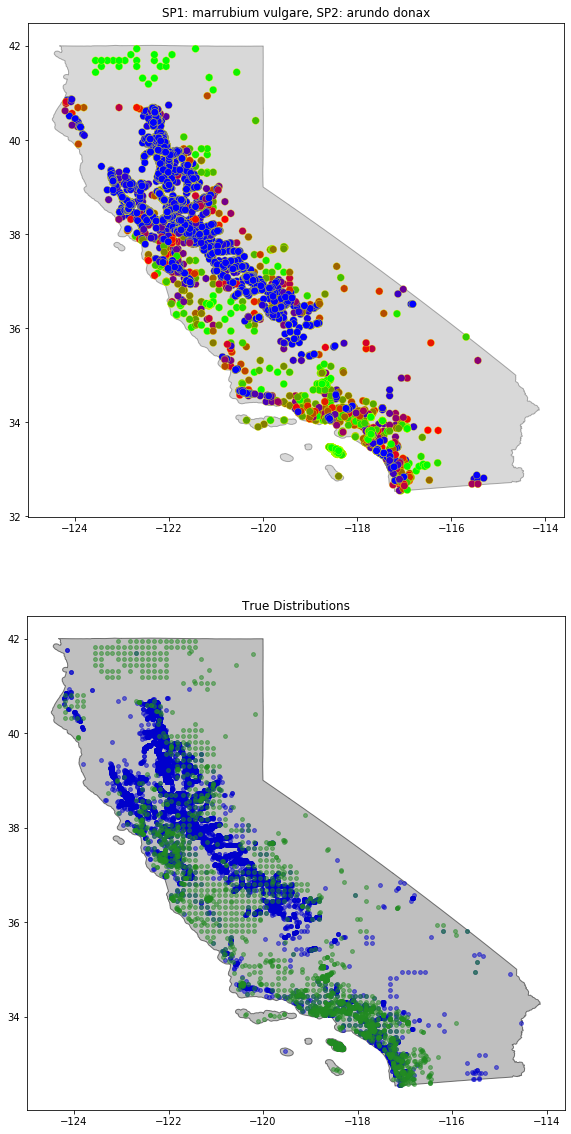

In [181]:
# let's first try this with two species
species = ['marrubium vulgare','arundo donax']

title = ', '.join(["SP%d: "%(n+1)+sp for n,sp in enumerate(species)])

x_test, train, new_observations, model = train_random_forest(species)
plot_model_pred ((x_test,train),title='SP1: '+species[0]+', SP2: '+species[1])

The above plot shows predicted species probability in the top figure and true observations in the bottom figure for the same two species we looked at previously (m. vulgare and a. donax).  Now, we see that the classifier distinguishes one species from another in a much more visually consistent way.

In [192]:
# plot the probability of observations belonging to a species using random samples
def plot_new_obs (obs,new_obs,plot_label='0',title='',vmax=1.0,exclude=0.01):
    
    geometry_obs = (geometry.loc[obs.index]).values
    geometry_new_obs = (geometry.loc[new_obs.index]).values

    # create geodataframe
    geo_df_obs = gpd.GeoDataFrame(obs,crs=crs,geometry=geometry_obs)
    geo_df_new_obs = gpd.GeoDataFrame(new_obs,crs=crs,geometry=geometry_new_obs)

    fig, ax1 = plt.subplots(figsize=(15,15))
    ca.plot(ax=ax1,alpha=0.3,color='grey',edgecolor='k')

    # create colormap for predicted probabilities
    norm = matplotlib.colors.Normalize(vmin=0,vmax=vmax)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.brg)
    _ = geo_df_new_obs[geo_df_new_obs['probability_'+plot_label]>exclude]
    colors = [mapper.to_rgba(x) for x in _['probability_'+plot_label].values]
    _.plot(ax=ax1,markersize=100,c=colors,label='0',alpha=0.4)
    geo_df_obs.plot(ax=ax1,markersize=25,color='white',label='0',edgecolor='k',linewidth=1.5)
    #geo_df_train[geo_df_train.labels==0].plot(ax=ax2,color='green',markersize=15)
    #geo_df_train[geo_df_train.labels==1].plot(ax=ax2,color='blue',markersize=15)
    
    ax1.set_title(title)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       985
           1       0.93      0.81      0.87       150

    accuracy                           0.97      1135
   macro avg       0.95      0.90      0.92      1135
weighted avg       0.97      0.97      0.97      1135

Accuracy: 0.9674008810572687


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


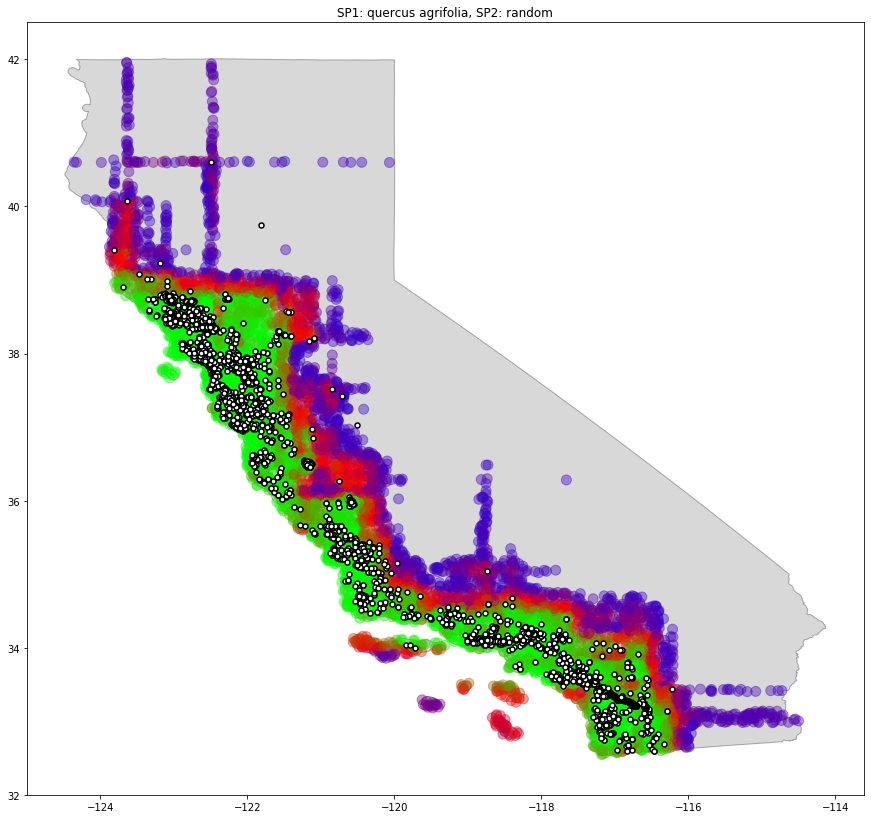

In [194]:
# now let's return to coast live oak and see the full species range the classifier is identifying
species = ['quercus agrifolia','random']

[sp1,sp2] = species
title = 'SP1: '+sp1+', SP2: '+sp2

x_test, train, new_observations, model = train_random_forest(species,n_randoms=500,generate_observations=20000)
plot_new_obs (df[(df.genus+' '+df.species)==species[0]],new_observations,title=title,vmax=1,exclude=0.1)

In this plot, I've train the random forest to predict whether an observation belongs to q. agrifolia (Coast Live Oak), or a set of random obsevations (random GPS locations within California).  This, hopefully, provides a sense for what the classifier believes to be the full range of q. agrifolia observations.  I've included the true distribution of q. agrifolia as white dots with black borders.  The colored points represent the likelyhood of an observation being classified as q. agrifolia: green 1 (100%), blue is 0 (values below 0.1 are not shown).

Interestingly, this plot also reveals some artifacts that result from the way the decision trees divide up the feature space (gps coordinates in this case) -- the strainght, low proability grid-like features in the plot.  This is not ideal, and suggests this is perhaps not the best approach to solving this problem.

### Multi-label Random Forest:  231 Most Common Species

In [8]:
# we'll now train on all common species
_ = df.groupby(df.genus+' '+df.species).id.count()
species = list(_[_>5000].sample(2).index)

#species = ['silybum marianum','digitalis purpurea']
#species = ['atriplex polycarpa','ehrharta erecta']
#species = ['pinus ponderosa','quercus agrifolia']
#species = ['marrubium vulgare','brassica tournefortii']
#species = ['quercus agrifolia','random']
#species = ['pinus ponderosa','random']
#species = ['pinus monophylla','random']
#species = ['centaurea melitensis','cynara cardunculus']
#species = ['quercus agrifolia','pinus ponderosa','pinus monophylla','centaurea melitensis','cynara cardunculus','silybum marianum','digitalis purpurea','marrubium vulgare','brassica tournefortii','random']

#species = list(_[_>2000].index)
species = list(_.index)
#if 'random' not in species:
#    species.append('random')

#title = ', '.join(["SP%d: "%(n+1)+sp for n,sp in enumerate(species)])
title = ''

#x_test, train, new_observations = train_random_forest(species)
#plot_model_pred ((x_test,train),n_classes=len(species),title=title,plot_label='0')

x_test, train, new_observations, model = train_random_forest(species,n_randoms=500,generate_observations=20000)
#plot_model_pred ((x_test,train),title='SP1: '+species[0]+', SP2: '+species[1])
#plot_new_obs (df[(df.genus+' '+df.species)==species[79]],new_observations,plot_label='79',title=species[79])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   20.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   20.6s finished


              precision    recall  f1-score   support

           0       0.08      0.09      0.09       633
           1       0.21      0.20      0.21       869
           2       0.80      0.81      0.80      1559
           3       0.58      0.57      0.57      1267
           4       0.41      0.42      0.41      1240
           5       0.90      0.88      0.89       636
           6       0.14      0.13      0.14       839
           7       0.03      0.03      0.03       631
           8       0.91      0.93      0.92     14819
           9       0.85      0.88      0.87      3549
          10       0.50      0.51      0.50      1461
          11       0.01      0.01      0.01      1047
          12       0.07      0.08      0.07       910
          13       0.86      0.89      0.87       618
          14       0.09      0.08      0.09       806
          15       0.62      0.67      0.64      1360
          16       0.03      0.03      0.03      1826
          17       0.01    

In [8]:
# note: this took up 44G of space!!!!
# thats a bit ridiculous...
#filename = 'random_forest_231_species.joblib'
#dump(model, filename) 
#pickle.dump(model, open(filename, 'wb'))

['random_forest_231_species.joblib']

In [68]:
# try using model to predict species likelihood:
#gps_coordinate = [-122.658334,38.216958] # helen putnam
#gps_coordinate = [-122.658334,38.219] # helen putnam
#gps_coordinate = [-122.912310,38.111464] # point reyes
#gps_coordinate = [-123.004553,37.999545] # point reyes near beach
#gps_coordinate = [-123.501912,39.104389] # perry gulch ranch
#gps_coordinate = [-120.172628,38.941386] # desolation wilderness
#gps_coordinate = [-121.888592,37.045244] # niscene marks
gps_coordinate = [-115.897894,33.835916] # joshua tree
#gps_coordinate = [-123.718345,39.375047] # jackson state demonstration forest
#gps_coordinate = [-122.640092,38.094934] # indian tree

def predict_species(gps_coordinate,location=''):
    # lookup common names
    common_names = df.groupby(df.genus+' '+df.species).common_name.agg(pd.Series.mode).to_dict()
    common_names['random'] = ''
    #print (common_names)
    #print (common_names)
    probs = model.predict_proba(np.array(gps_coordinate).reshape(1,-1))
    labels_dict = {n : s+' - '+common_names[s] for n,s in enumerate(species)}
    probs = pd.Series(probs[0]).sort_values(ascending=False)
    probs = probs[probs>0]
    # replace index
    probs.index = probs.index.map(labels_dict)
    print (location.upper())
    print (probs)
    print ('\n')


species = list(_[_>2000].index)
predict_species([-122.658334,38.216958], location='helen putnam')
predict_species([-122.912310,38.111464], location='point reyes')
predict_species([-123.004553,37.999545], location='point reyes (near beach)')
predict_species([-123.501912,39.104389], location='perry gulch ranch')
predict_species([-120.172628,38.941386], location='desolation wilderness')
predict_species([-121.888592,37.045244], location='niscene marks')
predict_species([-115.897894,33.835916], location='joshua tree')
predict_species([-123.718345,39.375047], location='jackson state demonstration forest')
predict_species([-122.640092,38.094934], location='indian tree')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


HELEN PUTNAM
centaurea solstitialis - yellow starthistle    0.89
centaurea calcitrapa - purple star thistle     0.05
genista monspessulana - french broom           0.03
rubus armeniacus - himalayan blackberry        0.03
dtype: float64




[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


POINT REYES
carduus pycnocephalus - italian thistle         0.290417
cytisus scoparius - scotch broom                0.290000
festuca arundinacea - reed fescue               0.140000
foeniculum vulgare - fennel                     0.100000
conium maculatum - poison hemlock               0.032742
rubus armeniacus - himalayan blackberry         0.030000
hedera helix - english ivy                      0.020000
leucanthemum vulgare - oxe eye daisy            0.020000
delairea odorata - cape ivy                     0.020000
phalaris aquatica - harding grass               0.010000
centaurea melitensis - tocalote                 0.005523
erodium cicutarium - coastal heron's bill       0.003820
eschscholzia californica - california poppy     0.003498
hypochaeris glabra - smooth cats ear            0.003301
polypogon monspeliensis - annual beard grass    0.003289
achillea millefolium - yarrow                   0.003142
bromus hordeaceus - soft chess                  0.003025
plantago lanceolata

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


POINT REYES (NEAR BEACH)
carpobrotus edulis - iceplant                   0.450000
cirsium vulgare - bullthistle                   0.383000
polypogon monspeliensis - annual beard grass    0.042667
holcus lanatus - common velvetgrass             0.034333
centaurea solstitialis - yellow starthistle     0.020000
conium maculatum - poison hemlock               0.020000
oxalis pes-caprae - bermuda buttercup           0.010000
hedera helix - english ivy                      0.010000
rubus armeniacus - himalayan blackberry         0.010000
genista monspessulana - french broom            0.010000
festuca arundinacea - reed fescue               0.010000
dtype: float64




[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


PERRY GULCH RANCH
bromus diandrus - ripgut brome                0.391500
bromus hordeaceus - soft chess                0.358500
artemisia douglasiana - california mugwort    0.080000
umbellularia californica - california bay     0.050000
delairea odorata - cape ivy                   0.040000
brassica nigra - black mustard                0.023333
lepidium latifolium - perennial pepperweed    0.020000
rumex crispus - curly dock                    0.016667
carduus pycnocephalus - italian thistle       0.010000
cirsium arvense - canada thistle              0.010000
dtype: float64




[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


DESOLATION WILDERNESS
cirsium vulgare - bullthistle                  0.247500
achillea millefolium - yarrow                  0.130000
verbascum thapsus - woolly mullein             0.128560
rumex acetosella - sheep sorrel                0.123706
lepidium latifolium - perennial pepperweed     0.092230
rumex crispus - curly dock                     0.085504
salsola tragus - russian thistle               0.050000
centaurea solstitialis - yellow starthistle    0.040000
taeniatherum caput-medusae - medusa head       0.030000
hypericum perforatum - klamathweed             0.030000
leucanthemum vulgare - oxe eye daisy           0.012500
aegilops triuncialis - goatgrass               0.010000
onopordum acanthium - scotch cottonthistle     0.010000
cytisus scoparius - scotch broom               0.010000
dtype: float64




[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


NISCENE MARKS
genista monspessulana - french broom           0.359072
heteromeles arbutifolia - toyon                0.096106
vinca major - vinca                            0.095470
baccharis pilularis - coyote brush             0.094757
adenostoma fasciculatum - chamise              0.089986
artemisia douglasiana - california mugwort     0.088957
mimulus aurantiacus - sticky monkeyflower      0.078990
toxicodendron diversilobum - poison oak        0.066661
centaurea solstitialis - yellow starthistle    0.010000
phalaris aquatica - harding grass              0.010000
avena barbata - slim oat                       0.010000
dtype: float64




[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


JOSHUA TREE
pennisetum setaceum - fountaingrass              0.510000
erodium cicutarium - coastal heron's bill        0.140305
brassica tournefortii - mustard                  0.081745
polypogon monspeliensis - annual beard grass     0.072877
tamarix ramosissima - tamarisk                   0.034583
mimulus aurantiacus - sticky monkeyflower        0.034333
eriogonum fasciculatum - california buckwheat    0.023678
atriplex polycarpa - cattle spinach              0.020000
hordeum murinum - foxtail barley                 0.016175
ephedra californica - desert tea                 0.015775
marrubium vulgare - white horehound              0.015495
juniperus californica - california juniper       0.014212
bromus tectorum - downy chess                    0.012528
bromus diandrus - ripgut brome                   0.008293
dtype: float64




[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


JACKSON STATE DEMONSTRATION FOREST
cirsium arvense - canada thistle               0.333125
genista monspessulana - french broom           0.091500
rubus armeniacus - himalayan blackberry        0.079929
plantago lanceolata - ribwort                  0.063195
carduus pycnocephalus - italian thistle        0.060000
foeniculum vulgare - fennel                    0.040250
cortaderia jubata - andean pampas grass        0.037595
cytisus scoparius - scotch broom               0.035636
bromus hordeaceus - soft chess                 0.024764
holcus lanatus - common velvetgrass            0.020916
torilis arvensis - field hedge parsley         0.020500
cortaderia selloana - pampas grass             0.020000
heteromeles arbutifolia - toyon                0.020000
delairea odorata - cape ivy                    0.020000
umbellularia californica - california bay      0.016417
cirsium vulgare - bullthistle                  0.012139
vinca major - vinca                            0.011750
lepidium lati

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


INDIAN TREE
carduus pycnocephalus - italian thistle        0.362138
rubus armeniacus - himalayan blackberry        0.173049
genista monspessulana - french broom           0.110000
toxicodendron diversilobum - poison oak        0.080000
quercus lobata - valley oak                    0.019347
plantago lanceolata - ribwort                  0.017751
medicago polymorpha - california burclover     0.016648
bromus diandrus - ripgut brome                 0.016228
rumex crispus - curly dock                     0.016050
baccharis pilularis - coyote brush             0.016042
hypochaeris glabra - smooth cats ear           0.015356
quercus agrifolia - coast live oak             0.015298
hordeum murinum - foxtail barley               0.014923
achillea millefolium - yarrow                  0.014319
torilis arvensis - field hedge parsley         0.013236
heteromeles arbutifolia - toyon                0.013119
silybum marianum - milk thistle                0.012481
dichelostemma capitatum - blue dicks

In [11]:
common_names = df.groupby(df.genus+' '+df.species).common_name.agg(pd.Series.mode).to_dict()
common_names['random'] = ''
labels_dict = {n : s+' - '+common_names[s] for n,s in enumerate(species)}

pd.set_option('display.max_rows', None)
print (pd.Series(labels_dict))

0                  acacia melanoxylon - blackwood acacia
1                      acer macrophyllum - bigleaf maple
2                          achillea millefolium - yarrow
3                             acmispon glaber - deerweed
4                      adenostoma fasciculatum - chamise
5                       aegilops triuncialis - goatgrass
6                         aesculus californica - buckeye
7                    ageratina adenophora - thoroughwort
8                   ailanthus altissima - tree of heaven
9                  aira caryophyllea - silvery hairgrass
10                allenrolfea occidentalis - iodine bush
11                       alnus rhombifolia - white alder
12                          ambrosia dumosa - burro weed
13              ammophila arenaria - european beachgrass
14                 amsinckia furcata - forked fiddleneck
15                      amsinckia menziesii - fiddleneck
16                anagallis arvensis - scarlet pimpernel
17                           ar

In [936]:
# Let's now try to increase number of samples in a given set of observations by using a random forest
# to distinguish this set from random observations.
new_observations=100000
latitude_min = df.latitude.min()
latitude_max = df.latitude.max()
longitude_min = df.longitude.min()
longitude_max = df.longitude.max()
random_latitudes = np.random.random(new_observations)*(latitude_max-latitude_min)+latitude_min
random_longitudes = np.random.random(new_observations)*(longitude_max-longitude_min)+longitude_min
random_geometry = [Point(x,y) for (x,y) in zip(random_longitudes,random_latitudes)]
# subset only the valid points
valid_points = np.where(np.array([ca.contains(p) for p in random_geometry]))[0]
random_geometry = pd.Series(random_geometry)[valid_points].values
print (len(random_geometry))
random_df = pd.DataFrame([random_longitudes,random_latitudes]).T
random_df.columns = ['longitude','latitude']
random_df = random_df.iloc[valid_points].reset_index()
random_df['genus'] = 'random'
random_df['species'] = 'random'

44491


Text(0.5, 1, 'Fake Random Observations in California')

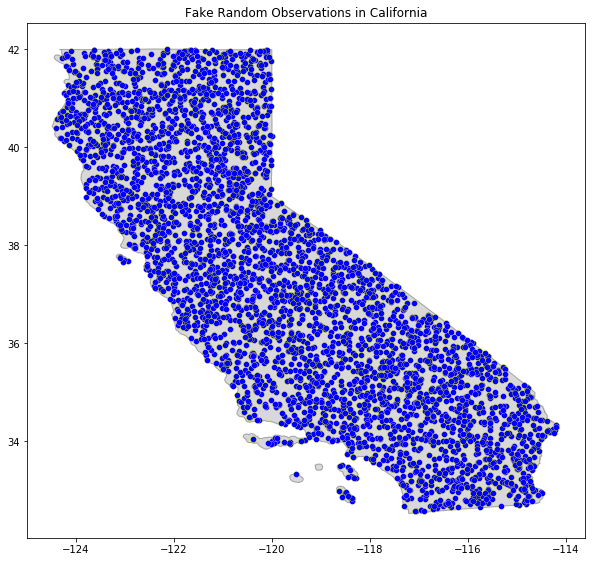

In [884]:
n_randoms_to_plot = 4000
geo_df_random = gpd.GeoDataFrame(random_geometry[:n_randoms_to_plot],crs=crs,geometry=random_geometry[:n_randoms_to_plot])

fig,ax = plt.subplots(figsize=(10,10))
ca.plot(ax=ax,alpha=0.3,color='grey',edgecolor='k')
geo_df_random.plot(ax=ax,markersize=35,color='blue',edgecolor='yellow',linewidth=0.3)
plt.title('Fake Random Observations in California')

### Kernel Density Estimator Approach

I'll try using a KDE approach to approximating probability distributions of species based on their observations.

In [67]:
# lets use scikit-learns gridsearchCV to find optimal kde bandwitdh for some species
_ = df.groupby(df.genus+' '+df.species).id.count()
species = _[_<3000].sample(10)

#species = 'quercus agrifolia'
#bestb = []

#print (species)
#for s in species.index.values:
#
#    train = df[(df.genus+' '+df.species)==s][['latitude','longitude']]
#
#    params = {'bandwidth': np.logspace(-1.2, -0.1, 20)}
#    grid = GridSearchCV(KernelDensity(), params)
#    grid.fit(train)
#    print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
#    bestb.append(grid.best_estimator_.bandwidth)
#    
#    
#np.median(np.array(bestb))

elymus glaucus                1673
euphorbia oblongata           1596
salvia columbariae            1118
claytonia perfoliata          1845
isocoma menziesii             1005
epilobium canum               1175
acer macrophyllum             1104
eriophyllum confertiflorum    1366
cirsium occidentale           1089
eriogonum nudum               1350
Name: id, dtype: int64


/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best bandwidth: 0.35696988468260643


/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best bandwidth: 0.06309573444801933


/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best bandwidth: 0.2734274456165233


/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best bandwidth: 0.20943662539726757


/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best bandwidth: 0.31241857136026663


/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best bandwidth: 0.35696988468260643


/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best bandwidth: 0.1404004245548316


/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best bandwidth: 0.10754220761125609


/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best bandwidth: 0.16042171611153241


/Users/christoph/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best bandwidth: 0.18329807108324356


0.19636734824025556

quercus agrifolia


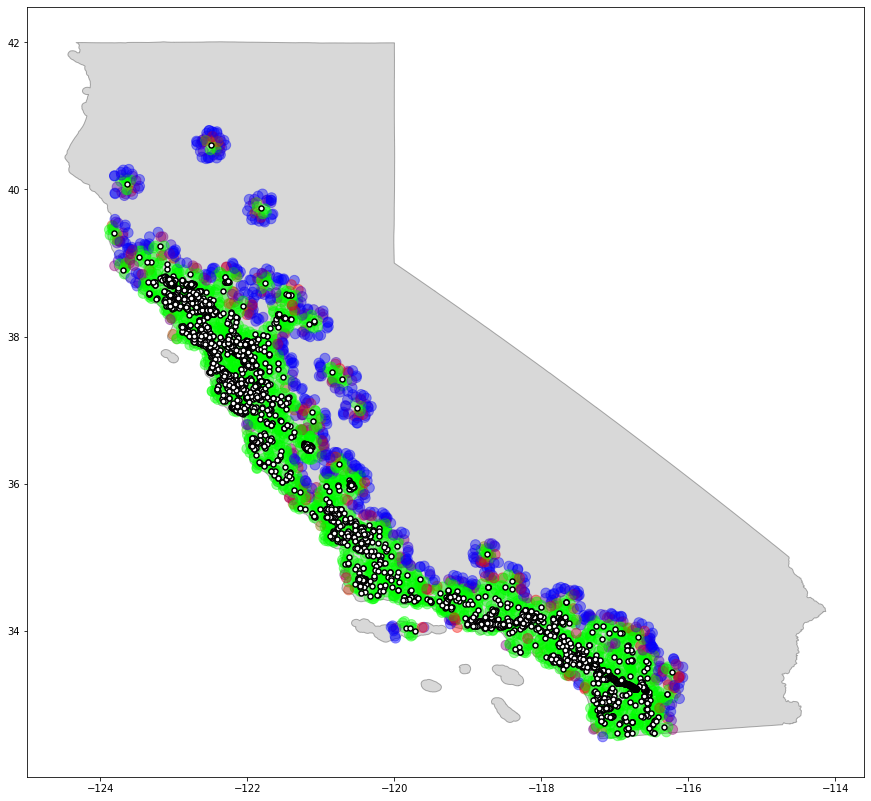

In [25]:
# now let's do this for all species using the same bandwidth for each
_ = df.groupby(df.genus+' '+df.species).id.count()
species = _[_>5000].sample(1).index[0]
species = 'quercus agrifolia'
print (species)

train_kde = df[(df.genus+' '+df.species)==species][['latitude','longitude']]

kde = KernelDensity(bandwidth=.05, kernel='gaussian')
kde.fit(train_kde)

# use random samples to score
_randoms = df[(df.genus+' '+df.species)=='random random'][['latitude','longitude']].sample(10000)
_scores = np.exp(kde.score_samples(_randoms))*len(train_kde)

geometry_obs = (geometry.loc[train_kde.index]).values
geometry_samples = (geometry.loc[_randoms.index]).values

geo_df_obs = gpd.GeoDataFrame(train_kde,crs=crs,geometry=geometry_obs)
geo_df_samples = gpd.GeoDataFrame(_randoms,crs=crs,geometry=geometry_samples)

fig, ax1 = plt.subplots(figsize=(15,15))
ca.plot(ax=ax1,alpha=0.3,color='grey',edgecolor='k')

# create colormap for predicted probabilities
norm = matplotlib.colors.Normalize(vmin=0,vmax=10)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.brg)
#_ = geo_df_samples[_scores>1]
colors = [mapper.to_rgba(x) for x in _scores[_scores>0.01]]
geo_df_samples.iloc[_scores>0.01].plot(ax=ax1,markersize=100,c=colors,label='0',alpha=0.4)
geo_df_obs.plot(ax=ax1,markersize=25,color='white',label='0',edgecolor='k',linewidth=1.5)

The above plot shows true observations of Coast Live Oak -- quercus agrifolia -- (white points with black borders), along with the probability density funciton estimate from our kernel density estimator (colored points).  Green points are regions of high density, red is intermediate, blue is very low density.  We are using a fairly low bandwidth here, and individual observations are seen as high probability regions.  This is probably about the best we can do using this approach.  If we increase the bandwidth much further, the estimated range of the species becomes quite broad, certainly averaging across ecosystem types and providing little variation with locality. 

In [26]:
# now let's compute kde for a bunch of species and predict their relative abundances
_ = df.groupby(df.genus+' '+df.species).id.count()
#species = _[_<2000].sample(100)
species = _
#species = 'quercus agrifolia'
print (species)

train_kde = df[(df.genus+' '+df.species).isin(species.index)][['longitude','latitude','genus','species']].copy(deep=True)
train_kde_taxon = (train_kde.genus+' '+train_kde.species)
train_kde = train_kde.drop(['genus','species'],axis=1)

kdes = {s:KernelDensity(bandwidth=0.05, kernel='gaussian') for s in species.index.values}

for s in species.index:
    kdes[s].fit(train_kde[train_kde_taxon==s])
    
#kde = KernelDensity(bandwidth=.2, kernel='gaussian')
#kde.fit(train)

acacia melanoxylon         1509
acer macrophyllum          1104
achillea millefolium       2207
acmispon glaber            1103
adenostoma fasciculatum    3026
                           ... 
volutaria tubuliflora      3198
vulpia myuros              3529
washingtonia filifera      1069
washingtonia robusta       2266
yucca brevifolia           1132
Name: id, Length: 232, dtype: int64


In [27]:
n_species_dict = {s : len(train_kde[train_kde_taxon==s]) for s in species.index.values}

### Species Predictor: KDE

Here, I'll implement the full KDE-based species predictor for all 231 species with more than 1000 observations.  We can then pass any GPS location and see a ranked readout of the speices with highest relative observation densities for that location.

Note: the output is scaled by the total number of observations of each species, and normalized to the density of a set of 'random' observations to provide a sense of relative likelihood.  This random set of observations is not associated with any species, and is composed of randomly generated GPS coordinates within the state of California.  The likelihood of observing randoms is fixed at one, so we can then compare values for other species to this reference point.

In [62]:
# now check the predicted value for each species at a given gps location
common_names = df.groupby(df.genus+' '+df.species).common_name.agg(pd.Series.mode).to_dict()
#common_names['random'] = ''
#common_names['random random'] = 'random'
labels_dict = {s : s+' - '+common_names[s] for n,s in enumerate(species.index.values)}

#print (species.index.values)

def predict_kde_gps (gps_coord,location=''):
    scores = np.zeros(len(species))
    _random_i = -1
    for i,s in enumerate(species.index.values):
        if s == 'random random':
            _random_i = i
        scores[i] = np.exp(kdes[s].score_samples(np.array(gps_coord).reshape(1,-1)))*n_species_dict[s]
    
    for i,s in enumerate(species.index.values):
        scores[i] /= scores[_random_i]
        
    #print (scores)
    scores = pd.Series(scores)
    scores.index = species.index
    scores.index = scores.index.map(labels_dict)
    scores = scores[scores>1e-3]
    scores = scores.sort_values(ascending=False)
    #scores /= np.linalg.norm(scores)
    print (location.upper())
    print (scores.iloc[:50])
    print ('\n')

In [63]:
#gps_coord = [-122.658334,38.216958] # helen putnam (true)
#gps_coord = [-122.658334,38.219] # helen putnam (nearby)
#gps_coord = [-122.912310,38.111464] # point reyes
#gps_coord = [-123.004553,37.999545] # point reyes (near beach)
#gps_coord = [-123.501912,39.104389] # perry gulch ranch
#gps_coord = [-120.172628,38.941386] # desolation wilderness
#gps_coord = [-121.888592,37.045244] # niscene marks
#gps_coord = [-115.897894,33.835916] # joshua tree
#gps_coord = [-123.718345,39.375047] # jackson state demonstration forest
#gps_coord = [-122.640092,38.094934] # indian tree

#predict_kde_gps(gps_coord)
predict_kde_gps([-122.658334,38.216958], location='helen putnam')
predict_kde_gps([-122.912310,38.111464], location='point reyes')
predict_kde_gps([-123.004553,37.999545], location='point reyes (near beach)')
predict_kde_gps([-123.501912,39.104389], location='perry gulch ranch')
predict_kde_gps([-120.172628,38.941386], location='desolation wilderness')
predict_kde_gps([-121.888592,37.045244], location='niscene marks')
predict_kde_gps([-115.897894,33.835916], location='joshua tree')
predict_kde_gps([-123.718345,39.375047], location='jackson state demonstration forest')
predict_kde_gps([-122.640092,38.094934], location='indian tree')

HELEN PUTNAM
rubus armeniacus - himalayan blackberry                   889.808427
silybum marianum - milk thistle                           573.140627
toxicodendron diversilobum - poison oak                   373.834619
umbellularia californica - california bay                 338.497085
sisyrinchium bellum - blue eyed grass                     275.637448
raphanus sativus - jointed charlock                       237.852779
rubus ursinus - california blackberry                     226.806809
torilis arvensis - field hedge parsley                    206.874268
vicia sativa - spring vetch                               205.150094
rumex acetosella - sheep sorrel                           196.022558
triteleia laxa - ithuriel's spear                         193.489054
trifolium hirtum - rose clover                            179.836796
rumex crispus - curly dock                                178.943122
sanicula crassicaulis - pacific sanicle                   171.485156
stellaria media - chi

PERRY GULCH RANCH
vinca major - vinca                                75.222883
trifolium hirtum - rose clover                     56.775872
torilis arvensis - field hedge parsley             56.437220
rumex acetosella - sheep sorrel                    56.383974
silybum marianum - milk thistle                    56.368313
rumex crispus - curly dock                         56.350295
rubus discolor - elmleaf blackberry                56.086706
vulpia myuros - rattail sixweeks grass             56.053469
taeniatherum caput-medusae - medusa head           55.985340
spartium junceum - spanish broom                   52.994522
umbellularia californica - california bay          48.501510
toxicodendron diversilobum - poison oak            46.856218
raphanus sativus - jointed charlock                34.272833
sisyrinchium bellum - blue eyed grass              25.291376
verbascum thapsus - woolly mullein                 19.584230
tamarix ramosissima - tamarisk                     19.547916
[]    

dtype: float64


INDIAN TREE
rubus armeniacus - himalayan blackberry                   4676.093275
silybum marianum - milk thistle                           2471.647361
sisyrinchium bellum - blue eyed grass                     1618.550088
toxicodendron diversilobum - poison oak                   1555.774229
umbellularia californica - california bay                 1424.129010
sanicula crassicaulis - pacific sanicle                   1404.651789
vicia sativa - spring vetch                               1374.362530
rumex acetosella - sheep sorrel                           1284.993027
triteleia laxa - ithuriel's spear                         1201.779577
sonchus asper - spiny sowthistle                          1074.421503
rubus ursinus - california blackberry                     1061.149165
vinca major - vinca                                       1049.403995
torilis arvensis - field hedge parsley                     991.610105
trifolium hirtum - rose clover                             88

## Concluding Remarks and Next Steps

In this analysis, I've implemented three different models: a binomial logistic classifier, a random forest classifier, and a kernel density estimator.  My goal was to predict which plant species (plural) I am most likely to observe in a given location within the state of California, preferably as a list ranked by relative likelihood.

I've developed two different predictors, both including 231 of the most observed species (all those with more than 1000 observations).  The random forest based predictor is much more expensive to run than the kernel density estimator, and is probably overkill for the limited feature data I have provided it for training (only GPS coordinate).  Ultimatly, I think there is a limited amount we can infer from the distribution of species observations when only considering their physical location.  We certainly can't infer the true distributions of these species, including variation from one local ecosystem to another.  What we can do is provide a broad estimate of species that are likely to be present in larger regions, as a whole, or on smaller scales to indiciate which species have been observed nearby.

Next, it would be very interesting to include additional feature data with each observation.  Features like date observed (already available), elevation, and some basic ecosystem / climate metrics (e.g. annual precipitation, terrain type, proximity to streams, cities, or roads) would allow for much more analysis of species environmental preferences and associations.  With this information, the random forest classifier would be a good candidate for extracting relationships in the features that would hopefully allow for much more accurate true distribution predictions.

#### Footnote: SQL Database

I initially stored my data in a SQLite database, but did not end up using much for this analysis, in favor of operating entirely with pandas.

In [269]:
# create a SQLite database and insert data

# create a connection to a new database file
conn = sqlite3.connect("records.db")

# dump data into the db
df.to_sql("all_records",conn)

In [274]:
# try reading some data using sql
pd.read_sql_query("SELECT genus, species, subspecies FROM all_records WHERE species LIKE 'edulis' LIMIT 1000",conn)

,genus,species,subspecies
0,Carpobrotus,edulis,None
1,Carpobrotus,edulis,None
2,Carpobrotus,edulis,None
3,Carpobrotus,edulis,None
4,Carpobrotus,edulis,None
...,...,...,...
995,Carpobrotus,edulis,None
996,Carpobrotus,edulis,None
997,Carpobrotus,edulis,None
998,Carpobrotus,edulis,None
